# Descriptive Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('space_decay_cleaned.csv')
df.head()

,Unnamed: 0,OBJECT_NAME,OBJECT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,...,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE
0,0,ARIANE 42P+ DEB,1992-072J,2021-10-31T22:46:50.340864,2.921700,0.652893,7.7156,90.2410,243.1216,38.7796,...,0.0,20668.618,492.864,27784.871,796.095,2,1,FR,1992.0,FRGUI
1,1,SL-8 DEB,1979-028C,2021-10-31T16:32:17.360448,13.754973,0.003072,82.9193,299.1120,158.9093,201.3337,...,0.0,7358.038,104.689,1002.507,957.299,2,0,CIS,1979.0,PKMTR
2,2,GSAT 1,2001-015A,2021-11-01T05:22:43.421952,1.038224,0.023739,12.1717,16.5368,250.1248,146.2900,...,0.0,41197.852,1386.984,35797.696,33841.738,0,2,IND,2001.0,SRI
3,3,CZ-4 DEB,1999-057MB,2021-10-31T11:11:24.198720,14.775907,0.006062,98.4781,8.7205,37.3771,323.1632,...,0.0,7015.076,97.456,679.465,594.417,2,0,PRC,1999.0,TSC
4,4,CZ-4 DEB,1999-057MC,2021-10-31T17:46:46.681248,14.724482,0.006226,98.4232,122.0724,345.1605,27.6061,...,0.0,7031.400,97.796,697.039,609.491,2,0,PRC,1999.0,TSC


## Feature Engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14125 entries, 0 to 14124
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         14125 non-null  int64  
 1   OBJECT_NAME        14125 non-null  object 
 2   OBJECT_ID          14125 non-null  object 
 3   EPOCH              14125 non-null  object 
 4   MEAN_MOTION        14125 non-null  float64
 5   ECCENTRICITY       14125 non-null  float64
 6   INCLINATION        14125 non-null  float64
 7   RA_OF_ASC_NODE     14125 non-null  float64
 8   ARG_OF_PERICENTER  14125 non-null  float64
 9   MEAN_ANOMALY       14125 non-null  float64
 10  NORAD_CAT_ID       14125 non-null  int64  
 11  REV_AT_EPOCH       14125 non-null  int64  
 12  BSTAR              14125 non-null  float64
 13  MEAN_MOTION_DOT    14125 non-null  float64
 14  MEAN_MOTION_DDOT   14125 non-null  float64
 15  SEMIMAJOR_AXIS     14125 non-null  float64
 16  PERIOD             141

### Necessary Adjustments

Epoch -->  2021-10-31T22:46:50.340864 (year-month-day T hour-minute-second-microsecond)  </br>
Launch_Date --> 1992.(year)

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df['EPOCH'] = pd.to_datetime(df['EPOCH'])

In [6]:
df = df.sort_values(by=['NORAD_CAT_ID', 'EPOCH']).reset_index(drop=True)

### Feature Extraction 

In [7]:
df['DAY_SINCE_FIRST_SEEN']=df.groupby('NORAD_CAT_ID')['EPOCH'].transform(lambda x: (x - x.min()).dt.days)
df['OBSERVATION_COUNT'] = df.groupby('NORAD_CAT_ID')['EPOCH'].transform('count')

In [8]:
df['ALTITUDE'] = (df['PERIAPSIS'] + df['APOAPSIS']) / 2
df['ALTITUDE_RANGE'] = df['APOAPSIS'] - df['PERIAPSIS']

In [9]:
df['ORBITAL_PERIOD'] = 2*np.pi*np.sqrt((df['SEMIMAJOR_AXIS']**3) / 398600.4418)

In [10]:
df['APOPERI_RATIO']= df['APOAPSIS']/df['PERIAPSIS']

In [11]:
# df['CROSS_SECTIONAL_AREA'] = 
# df['DRAG_EFFECTIVE_AREA'] = df['BSTAR']*df['CROSS_SECTIONAL_AREA']

In [26]:
def estimate_decay_time(row):
    if row['PERIAPSIS'] < 150:
        return 0
    else:
        periapsis = max(row['PERIAPSIS'], 150)
        bstar = max(row['BSTAR'], 1e-6)
        size_factor = 1 if row['RCS_SIZE'] == 0 else 1.5 if row['RCS_SIZE'] == 1 else 2

        estimated_time = (periapsis / (bstar * size_factor)) * 0.75
        return min(round(estimated_time), 10000)  # Cap at 10,000 days

df['ESTIMATED_DECAY_EPOCH'] = df.apply(estimate_decay_time, axis=1)
df['EPOCH'] = pd.to_datetime(df['EPOCH'], errors='coerce')

df['ESTIMATED_DECAY_EPOCH'] = df['EPOCH'] + pd.to_timedelta(df['ESTIMATED_DECAY_EPOCH'], unit='D')


In [28]:
df['ORBITAL_DECAY_TIME'] = (df['ESTIMATED_DECAY_EPOCH'] - df['EPOCH']).dt.days

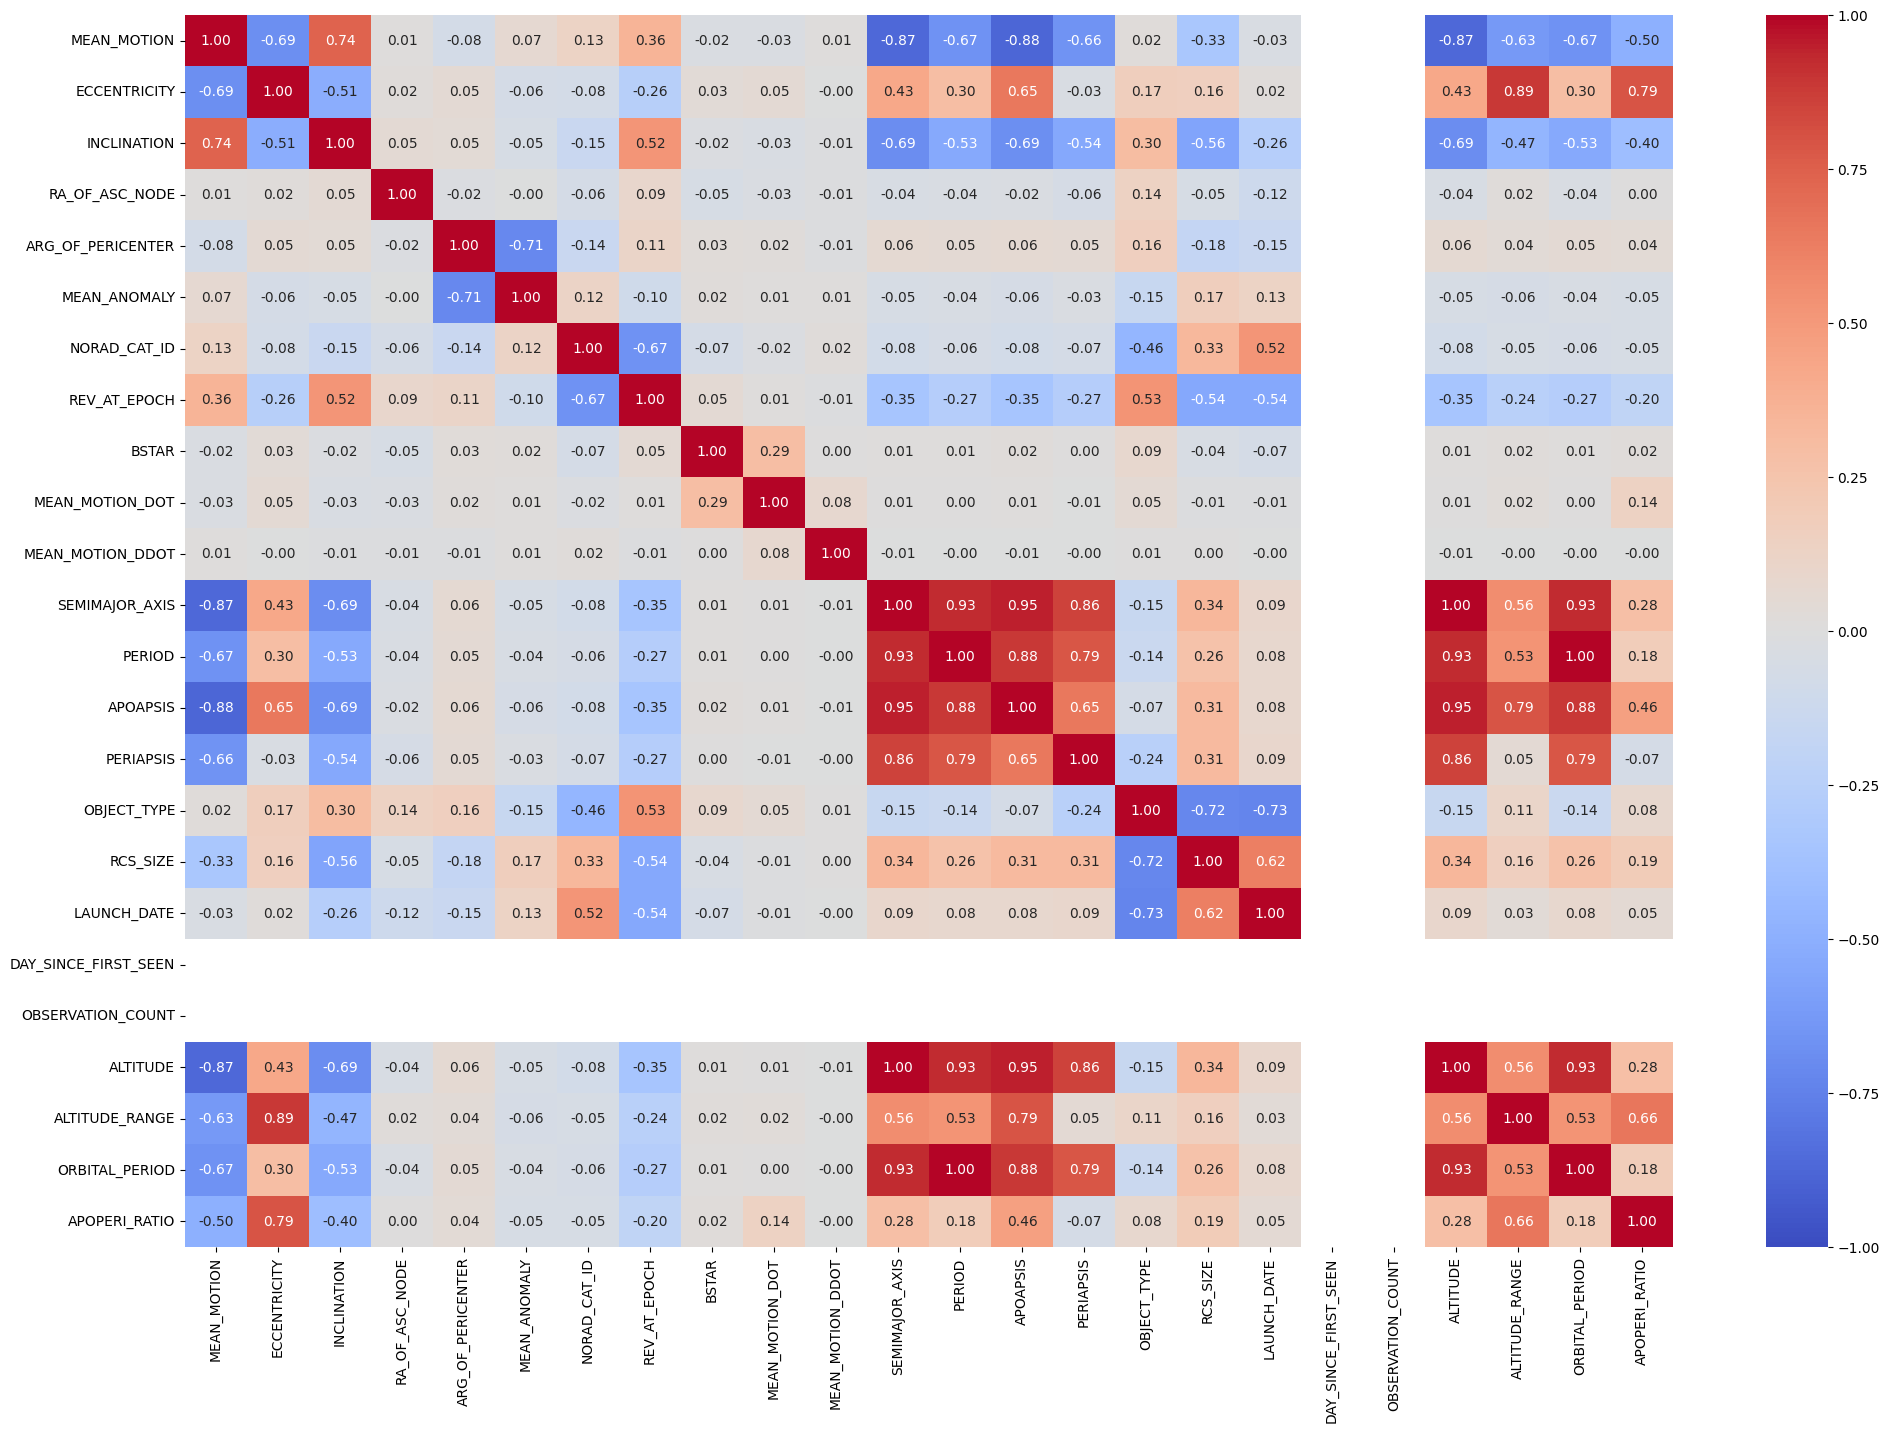

In [12]:
plt.figure(figsize=(24, 16))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm',  fmt=".2f", vmin=-1, vmax=1)
plt.show()